# CNN for IED forecasting

This notebook implements a simple CNN for IED classification. The CNN has 4 convolutional layers, each followed by ReLU activation functions and max pooling. The task in this notebook is single channel and is therefore a more simple task than what will eventually be implemented, but is useful to show what we can do with our data using a CNN.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, MaxPool1D
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [57]:
X = np.load('X.npy')
y = np.load('y.npy')

In [58]:
from scipy import signal

y = 1 * (y > 0)
zero = X[y == 0]
one = X[y == 1]

In [59]:
zero.shape, one.shape

((38631, 2048), (4689, 2048))

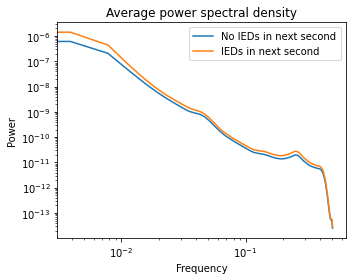

In [65]:
psds_zero = []
psds_one = []

freqs = signal.welch(zero[0])[0]
for zero_elem in zero:
    _, psd = signal.welch(zero_elem)
    psds_zero.append(psd)
    
psds_zero = np.array(psds_zero).mean(axis=0)

for one_elem in one:
    _, psd = signal.welch(one_elem)
    psds_one.append(psd)
    
psds_one = np.array(psds_one).mean(axis=0)
    
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
plt.semilogx(freqs, psds_zero, label='No IEDs in next second')
plt.semilogx(freqs, psds_one, label='IEDs in next second')
plt.title('Average power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
ax.set_yscale('log')
# plt.xlim([0, 5e-2])
plt.legend()
plt.tight_layout()

Open the data and create training and test sets.

In [14]:
# Load the input data
X = np.load('X.npy')[:200]

# Load the labels
y = np.load('y.npy')[:200]

# Conver to a classification task: does the following window have 2 or more IEDs?
y = 1 * (y > 2)

# Split into training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=1)

# Convert input data to [0, 1] range
scaler = MinMaxScaler()

# Fit to training data and transform both train & test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add dimension to make suitable for keras
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# As above for labels
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

We can see how balanced our data is:

In [15]:
np.sum(y_train > 0)/np.sum(y_train <= 0), np.sum(y_test > 0)/np.sum(y_test <= 0)

(0.5686274509803921, 0.6)

And can now define our model:

In [16]:
es = EarlyStopping(monitor="val_auc", patience=20, baseline=0.5, mode='max', restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=2, input_shape=X_train[0].shape, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
          
model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=8))

model.add(Conv1D(filters=8, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=8))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 20479, 8)          24        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5119, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5118, 16)          272       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1279, 16)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1278, 16)          528       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 159, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 158, 8)           

Which we can now fit:

In [17]:
# fit model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)#, callbacks=[es])#, class_weight=class_weight)

Epoch 1/100
4/4 [==============================] - 1s 154ms/step - loss: 0.6915 - auc_1: 0.5428 - val_loss: 0.6780 - val_auc_1: 0.5108
Epoch 2/100
4/4 [==============================] - 0s 72ms/step - loss: 0.6766 - auc_1: 0.5160 - val_loss: 0.6628 - val_auc_1: 0.6299
Epoch 3/100
4/4 [==============================] - 0s 71ms/step - loss: 0.6724 - auc_1: 0.5694 - val_loss: 0.6523 - val_auc_1: 0.7100
Epoch 4/100
4/4 [==============================] - 0s 72ms/step - loss: 0.6629 - auc_1: 0.5067 - val_loss: 0.6448 - val_auc_1: 0.6450
Epoch 5/100
4/4 [==============================] - 0s 71ms/step - loss: 0.6667 - auc_1: 0.5012 - val_loss: 0.6421 - val_auc_1: 0.6385
Epoch 6/100
4/4 [==============================] - 0s 71ms/step - loss: 0.6447 - auc_1: 0.4859 - val_loss: 0.6411 - val_auc_1: 0.6840
Epoch 7/100
4/4 [==============================] - 0s 71ms/step - loss: 0.6666 - auc_1: 0.4720 - val_loss: 0.6411 - val_auc_1: 0.7056
Epoch 8/100
4/4 [==============================] - 0s 71ms/st

Epoch 62/100
4/4 [==============================] - 0s 74ms/step - loss: 0.5497 - auc_1: 0.7613 - val_loss: 0.7843 - val_auc_1: 0.4502
Epoch 63/100
4/4 [==============================] - 0s 75ms/step - loss: 0.4870 - auc_1: 0.8381 - val_loss: 0.8144 - val_auc_1: 0.4502
Epoch 64/100
4/4 [==============================] - 0s 72ms/step - loss: 0.4614 - auc_1: 0.8546 - val_loss: 0.8000 - val_auc_1: 0.4524
Epoch 65/100
4/4 [==============================] - 0s 76ms/step - loss: 0.4969 - auc_1: 0.8170 - val_loss: 0.8012 - val_auc_1: 0.4481
Epoch 66/100
4/4 [==============================] - 0s 74ms/step - loss: 0.4990 - auc_1: 0.8227 - val_loss: 0.8057 - val_auc_1: 0.4416
Epoch 67/100
4/4 [==============================] - 0s 74ms/step - loss: 0.4778 - auc_1: 0.8354 - val_loss: 0.8408 - val_auc_1: 0.4459
Epoch 68/100
4/4 [==============================] - 0s 72ms/step - loss: 0.4999 - auc_1: 0.8204 - val_loss: 0.8252 - val_auc_1: 0.4437
Epoch 69/100
4/4 [==============================] - 0s 

We can visualise the training & validation loss over time:

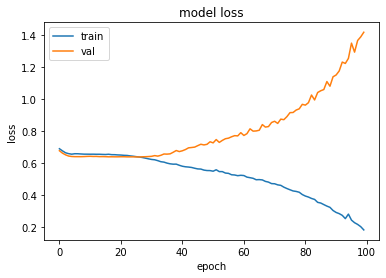

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As above for accuracy:

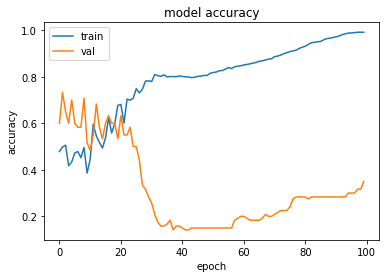

In [36]:
# summarize history for accuracy
plt.plot(history.history['auc_8'])
plt.plot(history.history['val_auc_8'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()